# CV Engineer Task: Data Loading & Model Training + Saving

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.onnx
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18, resnet50
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm 
import shap
import cv2

/home2/roja26/miniconda3/envs/new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part 1: Data Preprocessing

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

### I chose the **Fashion MNIST** dataset because it is **small in size**, allowing for **faster training** and experimentation without requiring extensive computational resources. 

## Perform EDA

In [4]:
# Perform EDA
classes = train_dataset.classes
print("Fashion MNIST Classes:", classes)

# Print image dimensions
print("Image Dimensions:", train_dataset[0][0].size)

Fashion MNIST Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Image Dimensions: (28, 28)


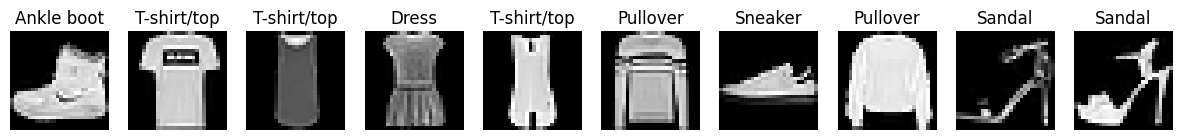

In [5]:
# Visualize some sample images
transform = transforms.ToTensor()
def show_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = transform(image).squeeze(0)  # Convert to grayscale if not already
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(classes[label])
        axes[i].axis("off")
    plt.show()

show_images(train_dataset)

### The Fashion MNIST dataset consists of 28×28 grayscale images of 70,000 fashion items across 10 categories. It serves as a drop-in replacement for MNIST but with more complex patterns, making it a better benchmark for machine learning models.

In [6]:
# Compute dataset mean & std for normalization
images = torch.stack([transform(train_dataset[i][0]) for i in range(len(train_dataset))])
mean = images.mean()
std = images.std()
print(f"Dataset Mean: {mean:.4f}, Std Dev: {std:.4f}")

Dataset Mean: 0.2860, Std Dev: 0.3530


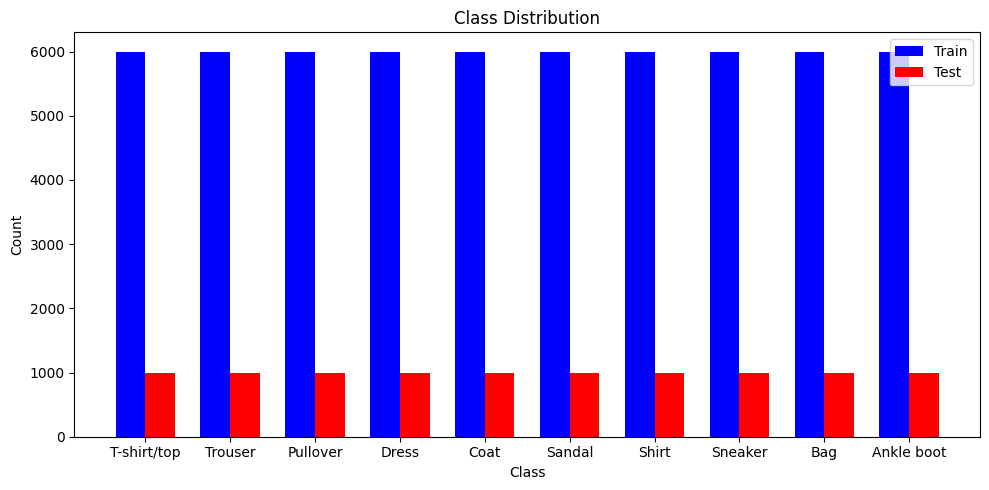

In [7]:
# Class distribution for train and test sets
train_class_counts = [0] * len(classes)
test_class_counts = [0] * len(classes)

for _, label in train_dataset:
    train_class_counts[label] += 1

for _, label in test_dataset:
    test_class_counts[label] += 1

x = np.arange(len(classes)) 
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, train_class_counts, width, label='Train', color='blue')
rects2 = ax.bar(x + width/2, test_class_counts, width, label='Test', color='red')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

fig.tight_layout()
plt.show()

### We observe that the classes are distributed equally in the train and test dataset of Fashion MNIST, implying that the dataset is balanced and does not suffer from class imbalance. This ensures that the model does not favor any particular class and can learn generalizable patterns across all categories, leading to fair and unbiased predictions during evaluation.

## Split data into train, val & test

In [8]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Apply transformations
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=False, transform=train_transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=False, transform=test_transform)

# Split into train & validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [9]:
# Check data shapes
data_iter = iter(train_loader)
images, labels = next(data_iter)
print("Training Data Shape:", images.shape, labels.shape)
print("Train Data Size:", len(train_loader.dataset))
print("Validation Data Size:", len(val_loader.dataset))
print("Test Data Size:", len(test_loader.dataset))

Training Data Shape: torch.Size([256, 1, 28, 28]) torch.Size([256])
Train Data Size: 48000
Validation Data Size: 12000
Test Data Size: 10000


### I am using a batch size of 256 to take advantage of the high memory capacity and parallel processing power of Nvidia GeForce RTX GPUs, allowing for faster training while maintaining stability. Additionally, I augment the training dataset by adding rotated and flipped versions of images to improve the model’s robustness against variations in orientation, ensuring it generalizes better to real-world scenarios. The `num_workers` parameter is set to 2 to enable efficient data loading by using two separate processes, balancing the speed of data fetching with GPU computation without overwhelming system resources.

# Part 2: Model Training & Evaluation

## Define Model

### ResNet18 is **sufficient for Fashion MNIST** because it provides **deep feature extraction** while being lightweight and efficient for a **small 28x28 grayscale dataset**. Modifying the first convolution layer for **single-channel input** and the final fully connected layer for **10 classes** ensures it is well-suited for the task.

In [10]:
# Define the model
class FashionMNIST_ResNet(nn.Module):
    def __init__(self):
        super(FashionMNIST_ResNet, self).__init__()
        self.model = models.resnet18(weights=None)  # No pre-trained weights
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for grayscale input
        self.model.fc = nn.Linear(512, 10)  # 10 classes
    
    def forward(self, x):
        return self.model(x)

# Initialize model, loss, optimizer
model = FashionMNIST_ResNet().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

## Train Model

The training process is optimized through multiple techniques to ensure efficiency, stability, and generalization.

**1. Model Training Process**  
- **Forward Pass:** The model takes grayscale **28x28** images as input, passes them through ResNet18, and produces class predictions.  
- **Loss Calculation:** Uses **CrossEntropyLoss** with **label smoothing (0.1)** to reduce overconfidence in predictions and improve generalization.  
- **Backward Pass:** Computes gradients and updates model weights using the **AdamW optimizer**, which combines **Adam's adaptive learning rates** with **L2 regularization (weight decay = 1e-4)** to prevent overfitting.  
- **Accuracy Calculation:** Predictions are compared with true labels to compute training and validation accuracy.  

**2. Optimization Techniques**  
- **Learning Rate Scheduling:** A **ReduceLROnPlateau scheduler** monitors validation loss and reduces the learning rate by **0.1** when performance plateaus (**patience = 3 epochs**).  
- **Early Stopping:** Training stops if validation loss does not improve for **5 consecutive epochs**, preventing overfitting and unnecessary computation.  
- **Best Model Saving:** The model is saved whenever validation loss improves, ensuring that the best-performing version is retained.  

By leveraging **deep feature extraction, adaptive learning rates, label smoothing, and early stopping**, the training process is made **efficient, stable, and generalizable** for Fashion MNIST classification.

In [11]:
# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    val_acc = 100. * correct / total
    return val_loss / len(loader), val_acc

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=5):
    best_val_loss = float('inf')
    early_stop_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_acc = 100. * correct / total
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

        # Save Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model Saved!")
        else:
            early_stop_counter += 1

        # Learning Rate Adjustment
        scheduler.step(val_loss)

        # Early Stopping Check
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

    return train_losses, val_losses

In [12]:
# Train the model
num_epochs = 30
train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/30: 100%|██████████| 188/188 [00:21<00:00,  8.59it/s]


Epoch 1: Train Loss=0.8518, Train Acc=84.25%, Val Loss=0.7786, Val Acc=87.80%
Model Saved!


Epoch 2/30: 100%|██████████| 188/188 [00:10<00:00, 17.71it/s]


Epoch 2: Train Loss=0.7360, Train Acc=89.49%, Val Loss=0.7395, Val Acc=89.08%
Model Saved!


Epoch 3/30: 100%|██████████| 188/188 [00:10<00:00, 18.22it/s]


Epoch 3: Train Loss=0.7127, Train Acc=90.39%, Val Loss=0.7265, Val Acc=89.67%
Model Saved!


Epoch 4/30: 100%|██████████| 188/188 [00:09<00:00, 19.92it/s]


Epoch 4: Train Loss=0.6933, Train Acc=91.17%, Val Loss=0.7350, Val Acc=89.32%


Epoch 5/30: 100%|██████████| 188/188 [00:10<00:00, 17.35it/s]


Epoch 5: Train Loss=0.6791, Train Acc=91.81%, Val Loss=0.6974, Val Acc=90.87%
Model Saved!


Epoch 6/30: 100%|██████████| 188/188 [00:10<00:00, 17.87it/s]


Epoch 6: Train Loss=0.6651, Train Acc=92.52%, Val Loss=0.7043, Val Acc=90.75%


Epoch 7/30: 100%|██████████| 188/188 [00:10<00:00, 17.69it/s]


Epoch 7: Train Loss=0.6557, Train Acc=92.86%, Val Loss=0.6755, Val Acc=92.12%
Model Saved!


Epoch 8/30: 100%|██████████| 188/188 [00:10<00:00, 17.51it/s]


Epoch 8: Train Loss=0.6485, Train Acc=93.23%, Val Loss=0.6895, Val Acc=91.33%


Epoch 9/30: 100%|██████████| 188/188 [00:10<00:00, 17.56it/s]


Epoch 9: Train Loss=0.6414, Train Acc=93.56%, Val Loss=0.6926, Val Acc=91.30%


Epoch 10/30: 100%|██████████| 188/188 [00:10<00:00, 18.17it/s]


Epoch 10: Train Loss=0.6330, Train Acc=93.86%, Val Loss=0.6712, Val Acc=92.25%
Model Saved!


Epoch 11/30: 100%|██████████| 188/188 [00:10<00:00, 17.73it/s]


Epoch 11: Train Loss=0.6285, Train Acc=94.13%, Val Loss=0.6693, Val Acc=92.26%
Model Saved!


Epoch 12/30: 100%|██████████| 188/188 [00:10<00:00, 18.07it/s]


Epoch 12: Train Loss=0.6207, Train Acc=94.63%, Val Loss=0.6690, Val Acc=92.29%
Model Saved!


Epoch 13/30: 100%|██████████| 188/188 [00:09<00:00, 18.95it/s]


Epoch 13: Train Loss=0.6179, Train Acc=94.66%, Val Loss=0.6795, Val Acc=91.84%


Epoch 14/30: 100%|██████████| 188/188 [00:10<00:00, 17.51it/s]


Epoch 14: Train Loss=0.6136, Train Acc=94.85%, Val Loss=0.6658, Val Acc=92.55%
Model Saved!


Epoch 15/30: 100%|██████████| 188/188 [00:10<00:00, 17.56it/s]


Epoch 15: Train Loss=0.6062, Train Acc=95.23%, Val Loss=0.6525, Val Acc=93.08%
Model Saved!


Epoch 16/30: 100%|██████████| 188/188 [00:10<00:00, 17.99it/s]


Epoch 16: Train Loss=0.6033, Train Acc=95.39%, Val Loss=0.6670, Val Acc=92.54%


Epoch 17/30: 100%|██████████| 188/188 [00:10<00:00, 17.61it/s]


Epoch 17: Train Loss=0.5964, Train Acc=95.70%, Val Loss=0.6860, Val Acc=91.73%


Epoch 18/30: 100%|██████████| 188/188 [00:10<00:00, 17.48it/s]


Epoch 18: Train Loss=0.5955, Train Acc=95.67%, Val Loss=0.6769, Val Acc=92.10%


Epoch 19/30: 100%|██████████| 188/188 [00:10<00:00, 17.73it/s]


Epoch 19: Train Loss=0.5910, Train Acc=95.93%, Val Loss=0.6665, Val Acc=92.53%


Epoch 20/30: 100%|██████████| 188/188 [00:10<00:00, 18.10it/s]


Epoch 20: Train Loss=0.5615, Train Acc=97.31%, Val Loss=0.6460, Val Acc=93.54%
Model Saved!


Epoch 21/30: 100%|██████████| 188/188 [00:10<00:00, 18.32it/s]


Epoch 21: Train Loss=0.5496, Train Acc=97.81%, Val Loss=0.6489, Val Acc=93.60%


Epoch 22/30: 100%|██████████| 188/188 [00:10<00:00, 17.71it/s]


Epoch 22: Train Loss=0.5465, Train Acc=97.98%, Val Loss=0.6455, Val Acc=93.71%
Model Saved!


Epoch 23/30: 100%|██████████| 188/188 [00:10<00:00, 17.64it/s]


Epoch 23: Train Loss=0.5420, Train Acc=98.24%, Val Loss=0.6487, Val Acc=93.81%


Epoch 24/30: 100%|██████████| 188/188 [00:10<00:00, 17.77it/s]


Epoch 24: Train Loss=0.5401, Train Acc=98.32%, Val Loss=0.6512, Val Acc=93.68%


Epoch 25/30: 100%|██████████| 188/188 [00:10<00:00, 17.81it/s]


Epoch 25: Train Loss=0.5364, Train Acc=98.47%, Val Loss=0.6509, Val Acc=93.73%


Epoch 26/30: 100%|██████████| 188/188 [00:10<00:00, 18.31it/s]


Epoch 26: Train Loss=0.5335, Train Acc=98.65%, Val Loss=0.6559, Val Acc=93.61%


Epoch 27/30: 100%|██████████| 188/188 [00:10<00:00, 17.78it/s]


Epoch 27: Train Loss=0.5317, Train Acc=98.74%, Val Loss=0.6559, Val Acc=93.58%
Early stopping triggered!


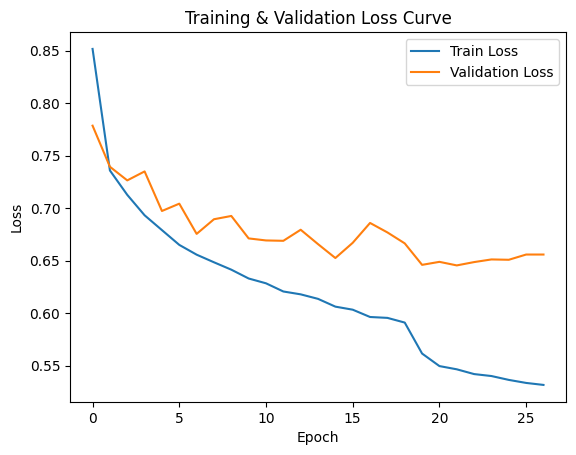

In [13]:
# Plot loss curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss Curve")
plt.show()

### We observe that both train and validation loss decrease during the training ensuring that the model is learning throughout the process. Early stopping was also triggered which means the model was starting to overfit, and hence the best model has been saved.

## Evaluate with Test Set

In [14]:
# Load Best Model
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
print("Best model loaded!")

# Test Evaluation
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    print(f"Test Accuracy: {100. * correct / total:.2f}%")
    return all_labels, all_preds

labels, preds = test(model, test_loader)

Best model loaded!


Test Accuracy: 93.64%


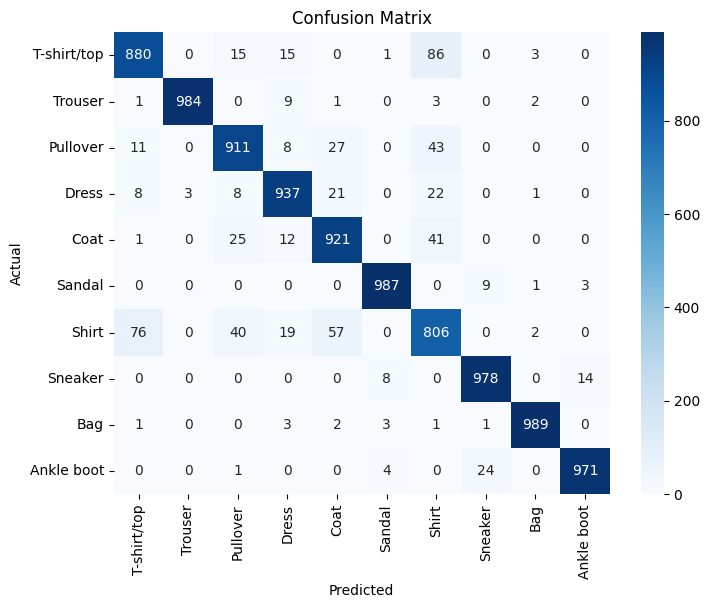

In [15]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### The model correctly classifies most of the 10 classes, each containing around 1,000 samples, with only a few misclassifications. However, we notice that visually similar categories, such as T-shirt/top and shirt, as well as shirt and coat, are sometimes confused. This suggests that the model struggles with subtle differences in shape and texture, which are inherently challenging even for human perception. These misclassifications highlight the overlap in features between certain fashion categories, making them harder to distinguish.

In [16]:
# Classification Report
print(classification_report(labels, preds, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.88      0.89      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.91      0.91      0.91      1000
       Dress       0.93      0.94      0.94      1000
        Coat       0.90      0.92      0.91      1000
      Sandal       0.98      0.99      0.99      1000
       Shirt       0.80      0.81      0.81      1000
     Sneaker       0.97      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



### The classification report provides key performance metrics: **precision**, **recall**, **F1-score**, and **support** for each class in the Fashion MNIST dataset. **Precision** measures the proportion of correct predictions among all predicted instances of a class, while **recall** indicates how many actual instances of a class were correctly identified. The **F1-score** is the harmonic mean of precision and recall, balancing both metrics. **Support** refers to the number of true instances for each class in the test set. The overall accuracy of 94% suggests strong model performance, but lower recall for similar classes like "Shirt" and "T-shirt/top" indicates confusion in distinguishing them.

## Save as onnx

### Note: Saved as cpu as the system on which inference is run need to use/have GPU. Mine did not.

In [17]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))
model.eval()

# Define a dummy input for Fashion MNIST
dummy_input = torch.randn(1, 1, 28, 28).to(device)

# Save model to ONNX
onnx_filename = "best_model_cpu.onnx"
torch.onnx.export(
    model, 
    dummy_input, 
    onnx_filename, 
    export_params=True, 
    opset_version=11, 
    do_constant_folding=True, 
    input_names=["input"], 
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)

print(f"Model saved as {onnx_filename}")

Model saved as best_model_cpu.onnx


# Bonus: Used SHAP for model explainability.

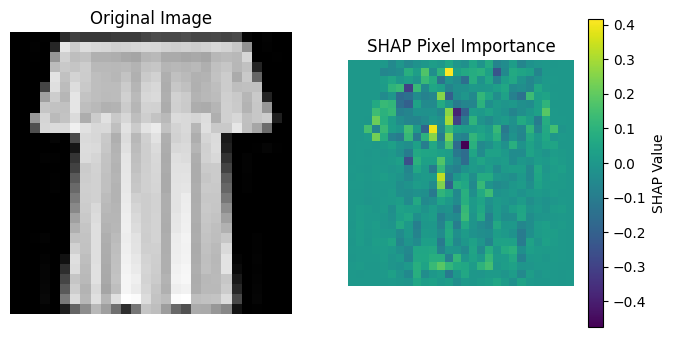

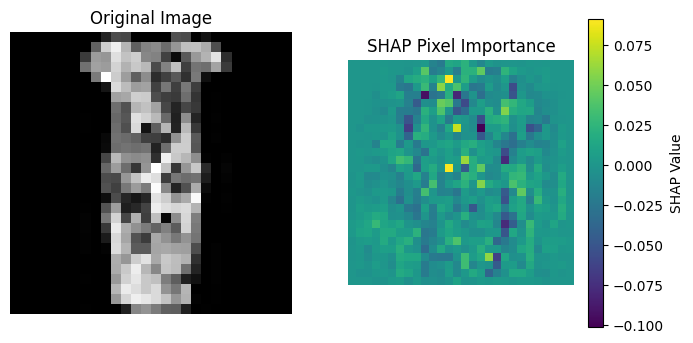

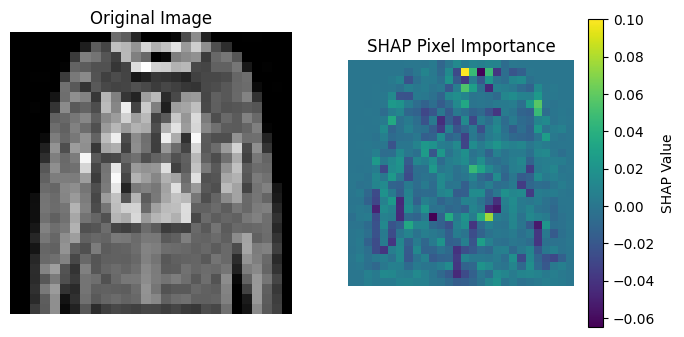

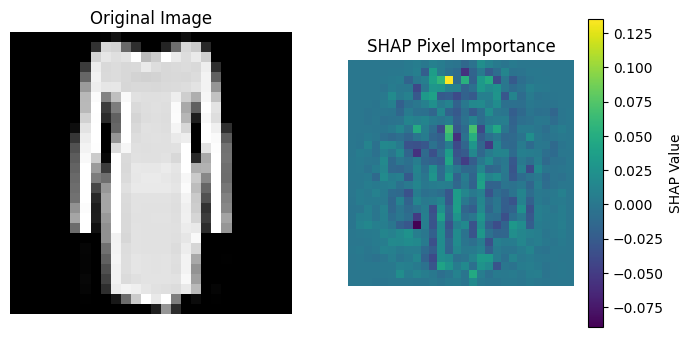

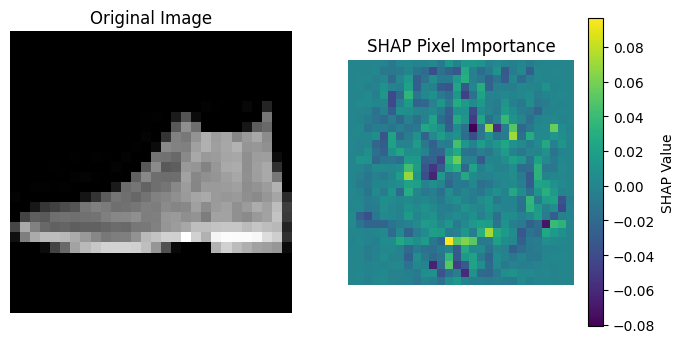

In [20]:
def get_background_samples(dataset, num_samples=100):
    idx = np.random.choice(len(dataset), num_samples, replace=False)
    return torch.stack([dataset[i][0] for i in idx]) 

def show_shap_explanation(image, shap_values):
    """Displays SHAP explanation as a heatmap."""
    shap_values = shap_values[0].squeeze().squeeze()  
    image = image.squeeze()  

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    # Original Image
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    # SHAP Values
    ax[1].imshow(shap_values, cmap="viridis")
    ax[1].set_title("SHAP Pixel Importance")
    cbar = ax[1].figure.colorbar(ax[1].imshow(shap_values, cmap="viridis"), ax=ax[1])
    cbar.set_label("SHAP Value")
    ax[1].axis("off")

    plt.show()

# Load Model and Data
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
model.eval()

# Visualize SHAP explanations for 5 samples
sample_indices = [2006, 100, 500, 1500, 0]  

for idx in sample_indices:
    image, label = test_dataset[idx]  
    input_tensor = image.unsqueeze(0).to(device)  
    background_samples = get_background_samples(test_dataset).to(device)
    explainer = shap.GradientExplainer(model, background_samples)
    shap_values = explainer.shap_values(input_tensor)  
    show_shap_explanation(image, shap_values)


### The SHAP heatmap highlights the most influential pixels in the classification decision. We observe that the high-importance regions in the heatmap align closely with the overall shape of the sample, indicating that the model focuses on key distinguishing features. These highlighted pixels correspond to defining characteristics of the clothing item, such as the neckline of a shirt or the sole of a shoe, which are crucial for differentiating between classes. This suggests that the model effectively identifies and prioritizes the most relevant visual patterns in its decision-making process.

# Load & Test Model Against One Sample

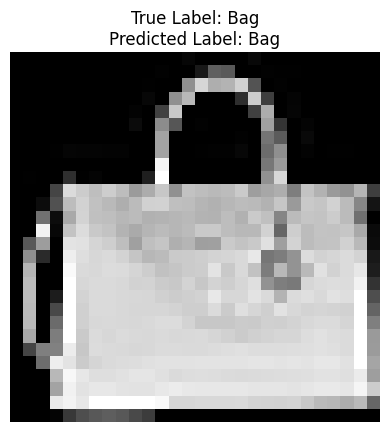

True

In [21]:
model = FashionMNIST_ResNet().to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
model.eval()

image, true_label = test_dataset[30] # random image from test dataset
classes = test_dataset.classes

def predict(image):
    input_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_label = torch.max(output, 1)
    return predicted_label.item()

def labelName(label):
    return classes[label]

plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"True Label: {labelName(true_label)}\nPredicted Label: {labelName(predict(image))}")
plt.show()

cv2.imwrite('testImage.png', image.squeeze().numpy() * 255) # save image